In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
data = pd.read_csv('data/mimiciv_vitalsign_23365149.csv')
data = data[data.offset > 150000]
data = data.drop('hadm_id', axis=1)
# data = pd.read_csv('data/mimiciv_vitalsign_28503629.csv')
# data = data[data.offset < 8000]

In [3]:
data.count()

offset         5146
heart_rate     3486
sbp            3643
dbp            3644
sbp_ni          993
dbp_ni          993
resp_rate      3515
temperature     973
spo2           3506
glucose         728
dtype: int64

In [4]:
data_reset_time = data.copy()
time_diff = data_reset_time['offset'] - data_reset_time['offset'].min()
data_reset_time['offset'] = time_diff

In [5]:
cols_to_plot = ['heart_rate', 'sbp', 'dbp', 'sbp_ni', 'dbp_ni', 'resp_rate', 'temperature', 'spo2', 'glucose']

In [6]:
def kernel_smoothing(data, time_col, feature_cols, bandwidth, interval):
    data_nona = data.sort_values(by=[time_col], ascending=True, inplace=False).interpolate(method='linear', limit_direction='both')
    times = np.linspace(data_nona.offset.iloc[0], data_nona.offset.iloc[-1], int((data_nona.offset.iloc[-1] - data_nona.offset[0]) / interval) + 1)
    res = pd.DataFrame(index=times)
    res[time_col] = times
    for col in feature_cols:
        kreg = KernelReg(endog=data_nona[col], exog=data_nona[time_col], var_type='c', bw=[bandwidth])
        res[col] = kreg.fit(times)[0]
    return res

In [7]:
data_smo2 = kernel_smoothing(data=data_reset_time, time_col='offset', feature_cols=cols_to_plot, bandwidth=1000, interval=60)

In [8]:
data_smo2.shape

(1211, 10)

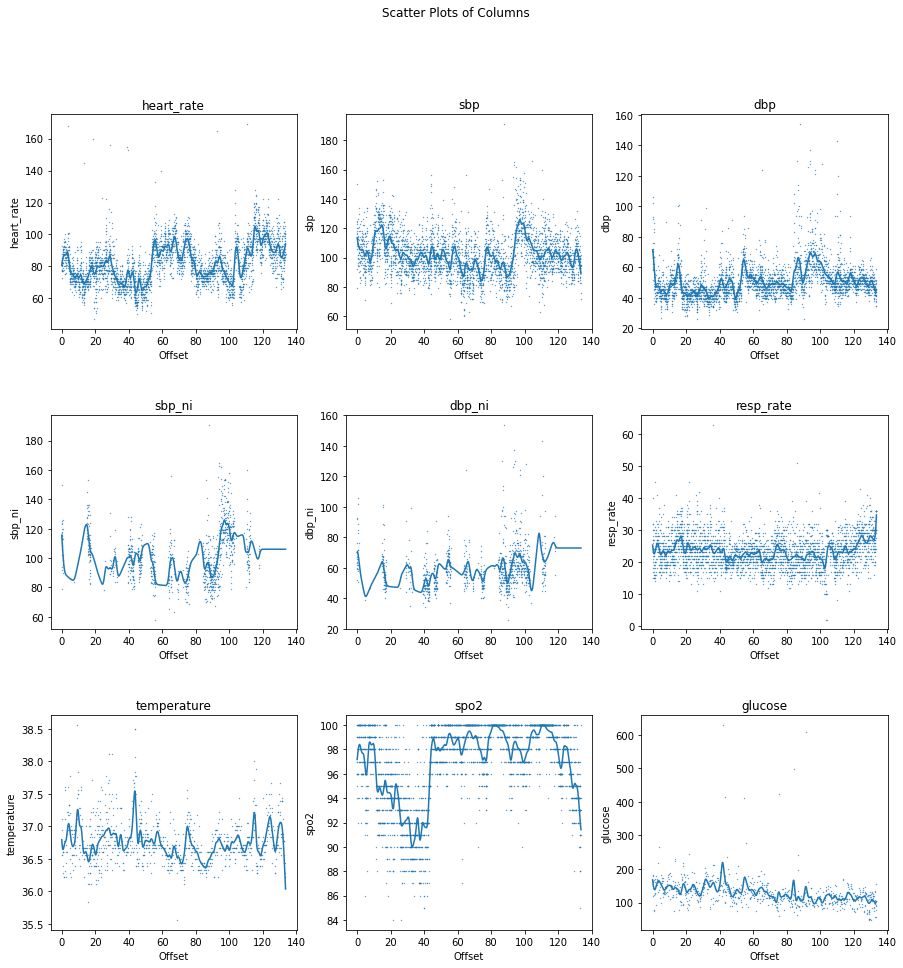

In [9]:
cols_to_plot = ['heart_rate', 'sbp', 'dbp', 'sbp_ni', 'dbp_ni', 'resp_rate', 'temperature', 'spo2', 'glucose']
# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Scatter Plots of Columns')
plt.subplots_adjust(hspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    ax.plot(data_smo2.offset / 1440, data_smo2[name])
    ax.scatter(data_reset_time.offset / 1440, data_reset_time[name], s=.1)
    ax.set_title(f'{name}')
    ax.set_xlabel('Offset')
    ax.set_ylabel(name)

# Add a legend for all subplots
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.025), ncol=len(cols_to_plot))

plt.show()

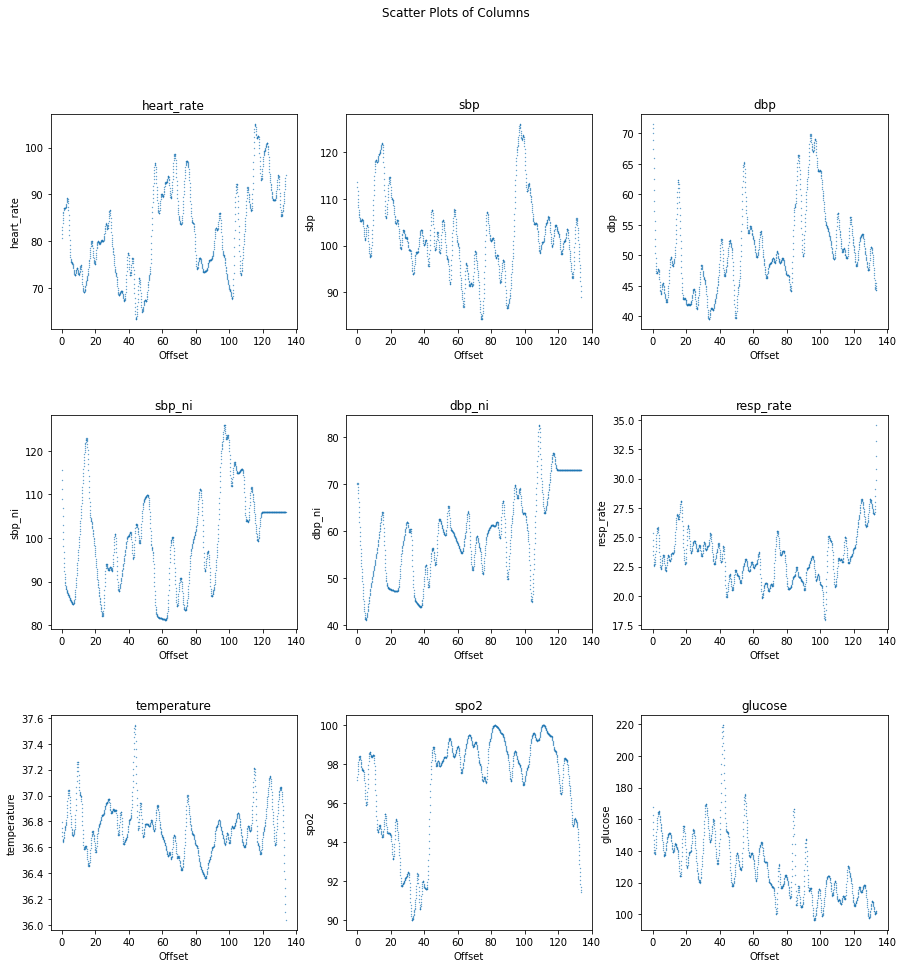

In [10]:
cols_to_plot = ['heart_rate', 'sbp', 'dbp', 'sbp_ni', 'dbp_ni', 'resp_rate', 'temperature', 'spo2', 'glucose']
# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Scatter Plots of Columns')
plt.subplots_adjust(hspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    ax.scatter(data_smo2.offset / 1440, data_smo2[name], s=.1)
    ax.set_title(f'{name}')
    ax.set_xlabel('Offset')
    ax.set_ylabel(name)

# Add a legend for all subplots
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.025), ncol=len(cols_to_plot))

plt.show()

In [11]:
data_smo2.to_csv('data/mimic_data_smooth_hourly.csv', index=False)

In [12]:
from experiment_utils import add_noise, get_graph, get_graph_magic, visuallize_graph, denoise_experiment, compare_denoised_signal

In [37]:
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
import pygsp
points = np.linspace(1, 10, 10).reshape(-1, 1)
def create_line_graph(points, lam, threshold):
    D = cdist(points, points)
    W = np.exp(-np.square(D) / (2 * lam ** 2))
    W[W < threshold] = 0
    Ws = csr_matrix(W)
    graph = pygsp.graphs.Graph(Ws)
    t_plot = points - points.min()
    t_plot = t_plot / t_plot.max() * np.pi
    graph.set_coordinates(np.c_[np.cos(t_plot), np.sin(t_plot)])
    return graph

In [53]:
graph = create_line_graph(data_smo2.offset.to_numpy().reshape(-1, 1), 500, 0.5)

2023-05-01 10:12:38,205:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


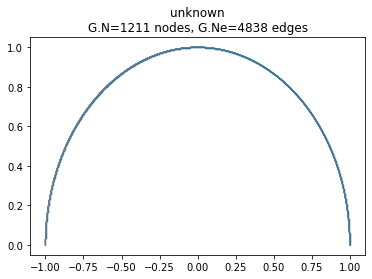

In [54]:
pygsp.plotting.plot_graph(graph, vertex_size=1)

In [55]:
import scanpy as sc
data = data_smo2[cols_to_plot].to_numpy()
adata = sc.AnnData(X=data, dtype=data.dtype)

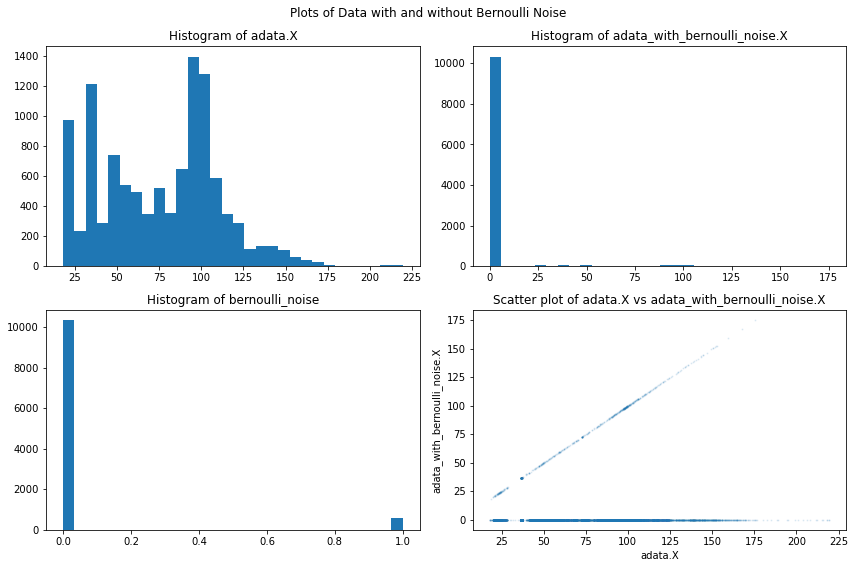

In [56]:
adata_bernoulli = add_noise(adata, noise_type='bernoulli', probability=0.05)

In [57]:
data_noisy = data_smo2.copy()
data_noisy[cols_to_plot] = adata_bernoulli.X

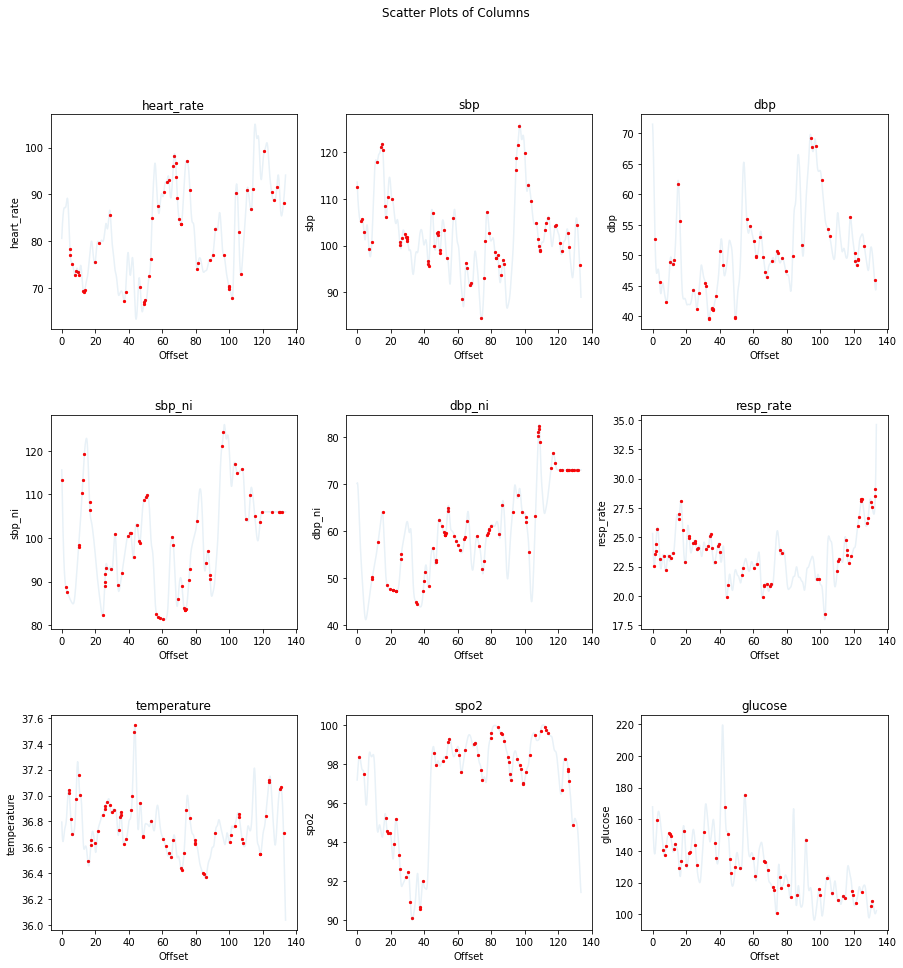

In [58]:
cols_to_plot = ['heart_rate', 'sbp', 'dbp', 'sbp_ni', 'dbp_ni', 'resp_rate', 'temperature', 'spo2', 'glucose']
# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Scatter Plots of Columns')
plt.subplots_adjust(hspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    ax.plot(data_smo2.offset / 1440, data_smo2[name], alpha=.1)
    plot_points = data_noisy[name] != 0
    ax.scatter(data_noisy.offset[plot_points] / 1440, data_noisy[name][plot_points], s=5, c='red')
    ax.set_title(f'{name}')
    ax.set_xlabel('Offset')
    ax.set_ylabel(name)

# Add a legend for all subplots
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.025), ncol=len(cols_to_plot))

plt.show()

100%|██████████| 500/500 [00:00<00:00, 2846.94it/s]


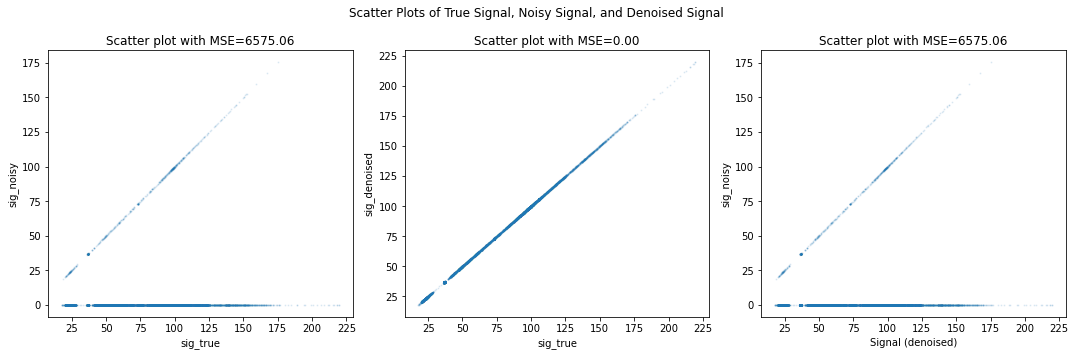

In [59]:
pygsp_graph = graph
sig_denoised_bernoulli = denoise_experiment(pygsp_graph, adata_bernoulli.X, 'bernoulli')
mse_dict_bernoulli = compare_denoised_signal(adata.X, adata_bernoulli.X, adata.X)

In [60]:
data_denoised = data_smo2.copy()
data_denoised[cols_to_plot] = sig_denoised_bernoulli

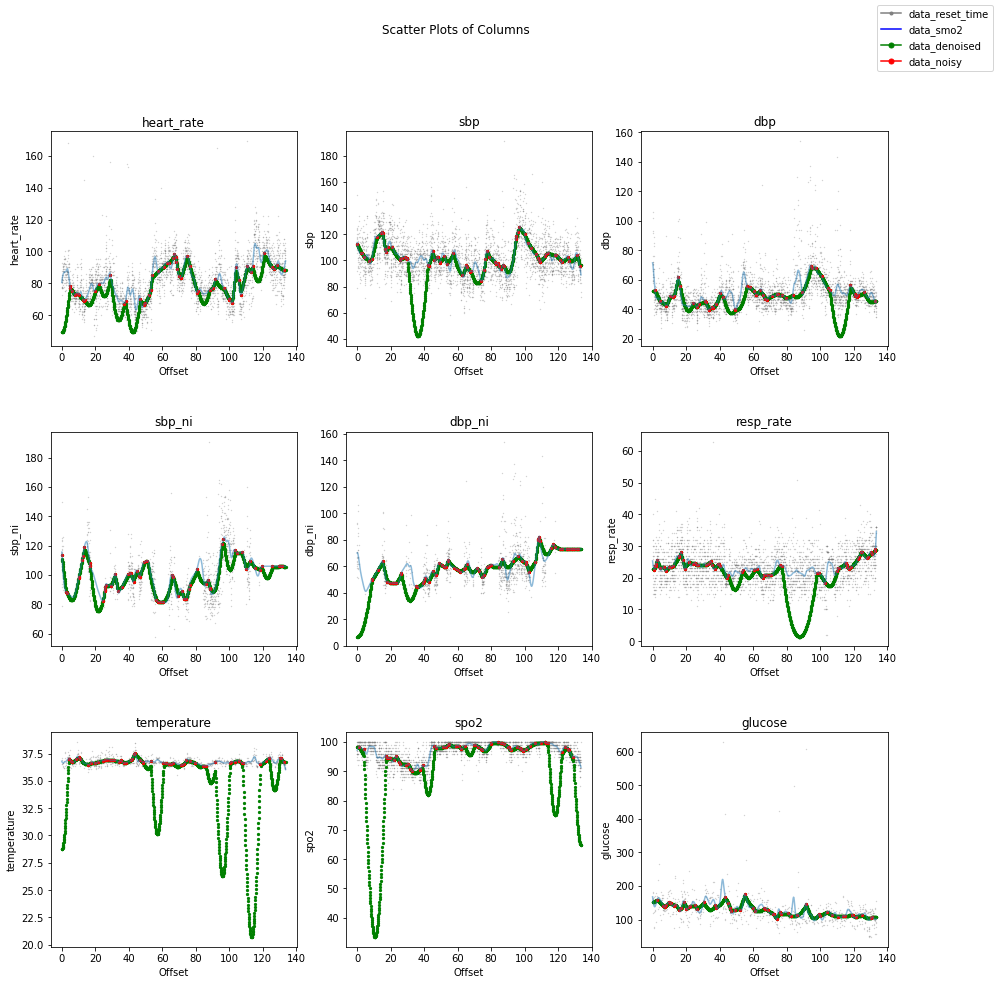

In [61]:
from matplotlib.lines import Line2D

cols_to_plot = ['heart_rate', 'sbp', 'dbp', 'sbp_ni', 'dbp_ni', 'resp_rate', 'temperature', 'spo2', 'glucose']
# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Scatter Plots of Columns')
plt.subplots_adjust(hspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    ax.scatter(data_reset_time.offset / 1440, data_reset_time[name], s=.1, c='gray', alpha=.5)
    ax.plot(data_smo2.offset / 1440, data_smo2[name], alpha=.5)
    ax.scatter(data_denoised.offset / 1440, data_denoised[name], s=5, c='green')
    plot_points = data_noisy[name] != 0
    ax.scatter(data_noisy.offset[plot_points] / 1440, data_noisy[name][plot_points], s=5, c='red')
    ax.set_title(f'{name}')
    ax.set_xlabel('Offset')
    ax.set_ylabel(name)

    # Create the global legend
    legend_elements = [
        Line2D([0], [0], color='gray', marker='o', markersize=3, label='data_reset_time'),
        Line2D([0], [0], color='blue', label='data_smo2'),
        Line2D([0], [0], color='green', marker='o', markersize=5, label='data_denoised'),
        Line2D([0], [0], color='red', marker='o', markersize=5, label='data_noisy')
    ]
fig.legend(handles=legend_elements)



plt.show()

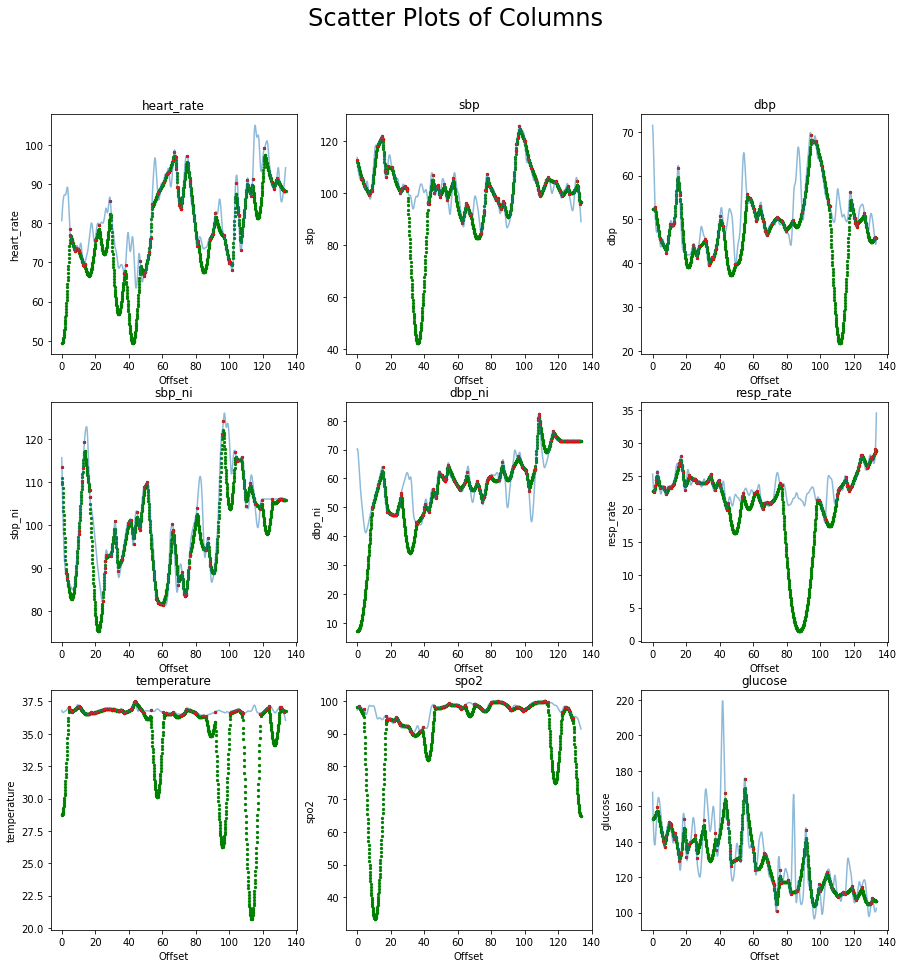

In [62]:
cols_to_plot = ['heart_rate', 'sbp', 'dbp', 'sbp_ni', 'dbp_ni', 'resp_rate', 'temperature', 'spo2', 'glucose']
# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Scatter Plots of Columns', fontsize=24)
# plt.subplots_adjust(hspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    ax.plot(data_smo2.offset / 1440, data_smo2[name], alpha=.5)
    ax.scatter(data_denoised.offset / 1440, data_denoised[name], s=5, c='green')
    plot_points = data_noisy[name] != 0
    ax.scatter(data_noisy.offset[plot_points] / 1440, data_noisy[name][plot_points], s=5, c='red')
    # ax.scatter(data_reset_time.offset / 1440, data_reset_time[name], s=.1)
    ax.set_title(f'{name}')
    ax.set_xlabel('Offset')
    ax.set_ylabel(name)

# Add a legend for all subplots
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.025), ncol=len(cols_to_plot))

plt.show()

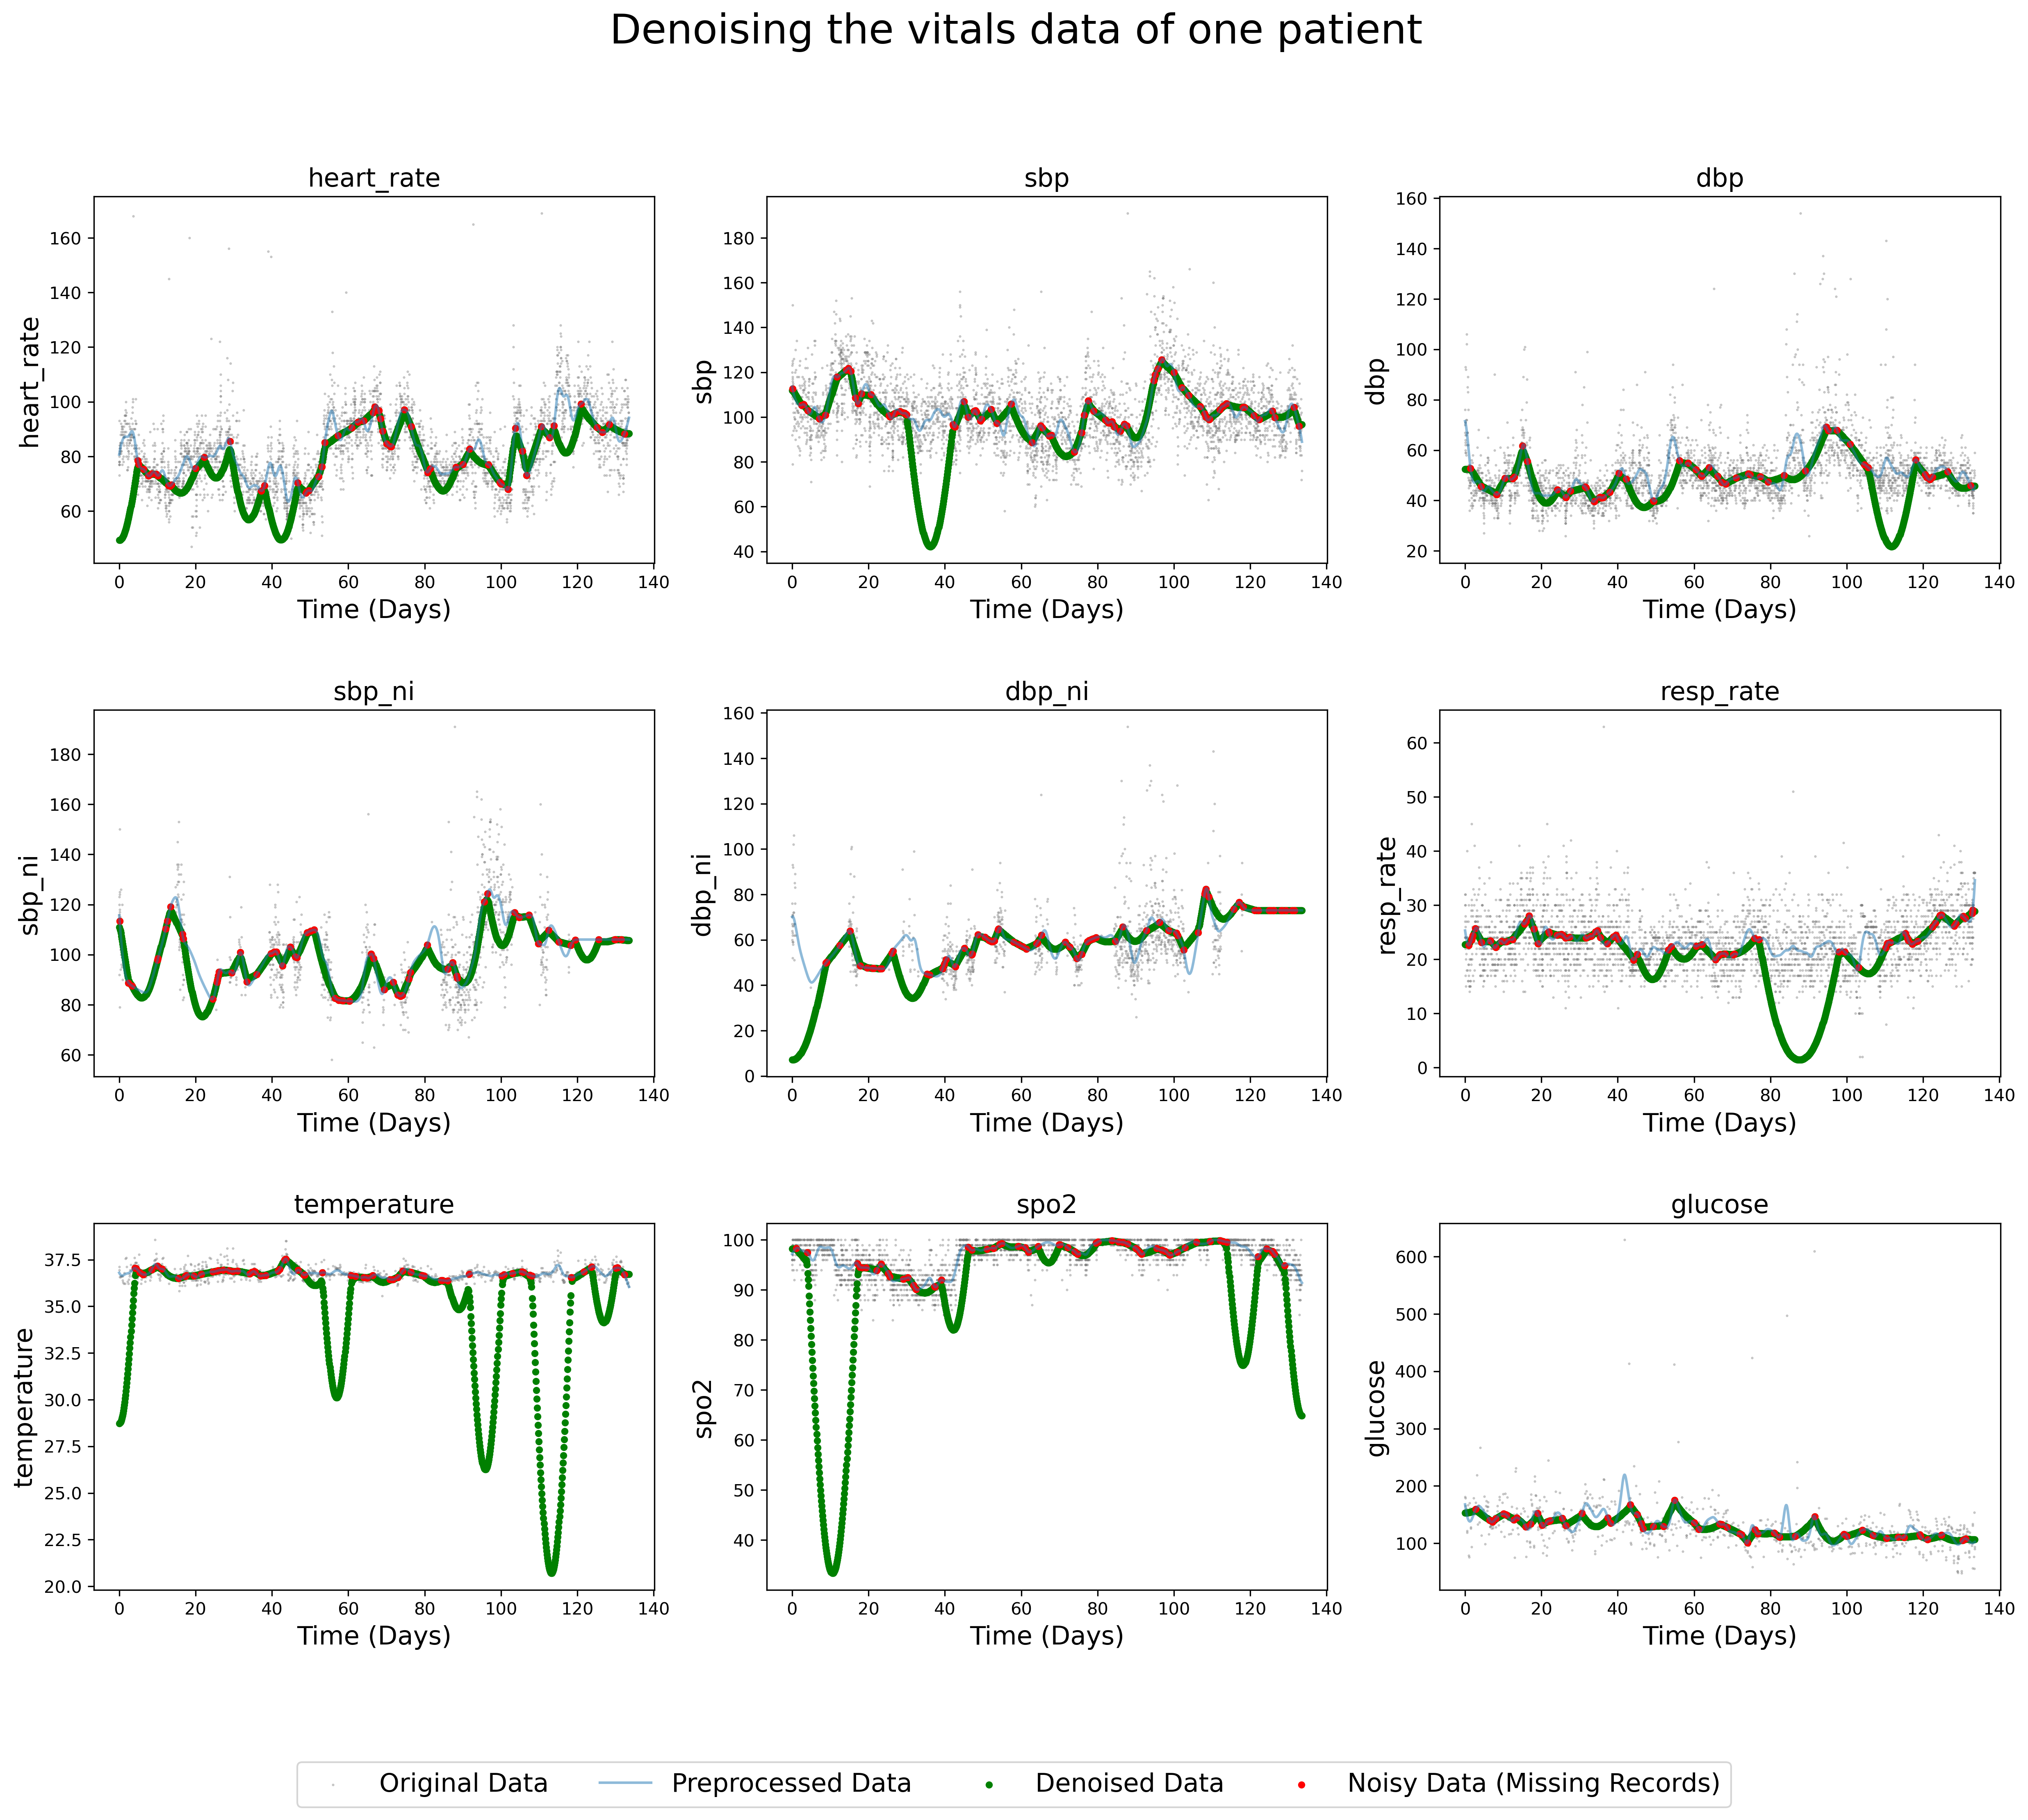

In [63]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), dpi=300)
fig.suptitle('Denoising the vitals data of one patient', fontsize=24)
plt.subplots_adjust(hspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    ax.scatter(data_reset_time.offset / 1440, data_reset_time[name], s=.2, c='gray', alpha=.5, label='Original Data')
    ax.plot(data_smo2.offset / 1440, data_smo2[name], alpha=.5, label='Preprocessed Data')
    ax.scatter(data_denoised.offset / 1440, data_denoised[name], s=10, c='green', label='Denoised Data')
    plot_points = data_noisy[name] != 0
    ax.scatter(data_noisy.offset[plot_points] / 1440, data_noisy[name][plot_points], s=10, c='red', label='Noisy Data (Missing Records)')
    ax.set_title(f'{name}', fontsize=15)
    ax.set_xlabel('Time (Days)', fontsize=15)
    ax.set_ylabel(name, fontsize=15)

# Create a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=15)

plt.show()


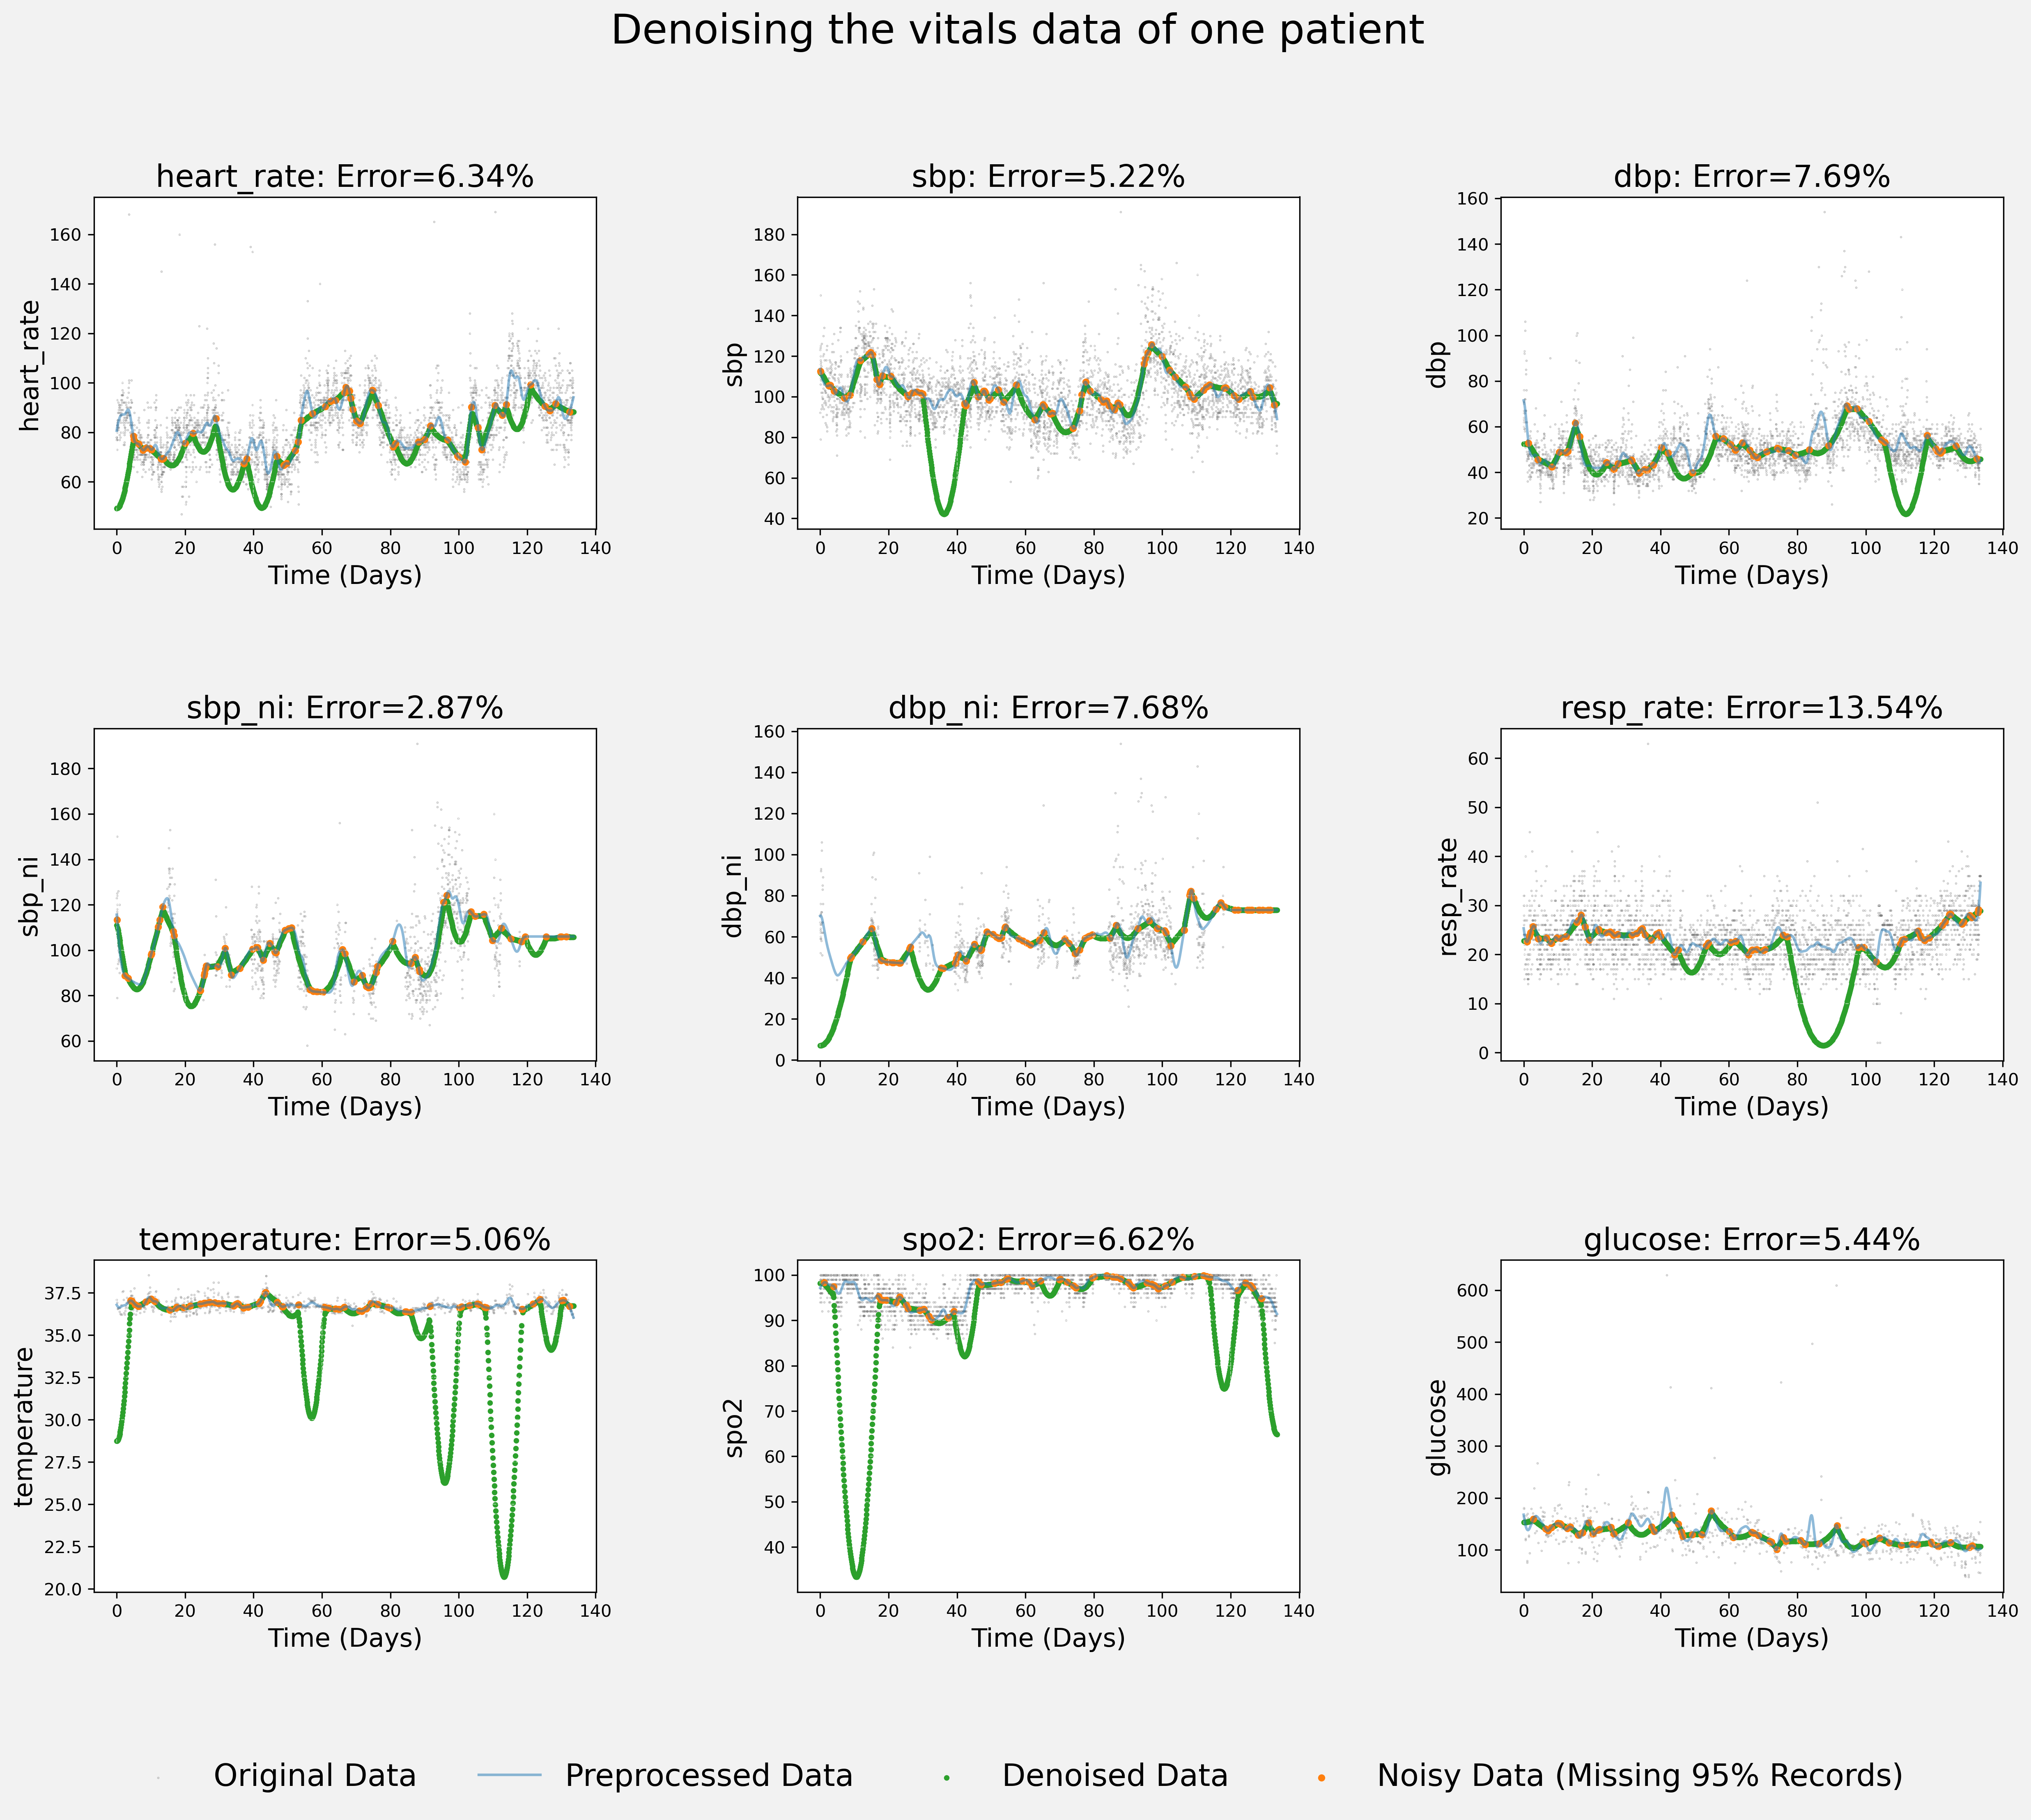

In [64]:
import matplotlib.pyplot as plt

# Set a consistent color scheme
colors = ['#1f77b4', '#aec7e8', '#2ca02c', '#ff7f0e']

# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), dpi=300)
fig.set_facecolor('#f2f2f2')
fig.suptitle('Denoising the vitals data of one patient', fontsize=24, fontname='Arial')
plt.subplots_adjust(hspace=0.6, wspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    ax.scatter(data_reset_time.offset / 1440, data_reset_time[name], s=.1, c='gray', alpha=.5, label='Original Data')
    ax.plot(data_smo2.offset / 1440, data_smo2[name], alpha=.5, c=colors[0], label='Preprocessed Data')
    ax.scatter(data_denoised.offset / 1440, data_denoised[name], s=5, c=colors[2], label='Denoised Data')
    plot_points = data_noisy[name] != 0
    ax.scatter(data_noisy.offset[plot_points] / 1440, data_noisy[name][plot_points], s=10, c=colors[3], label='Noisy Data (Missing 95% Records)')
    ax.set_title(f'{name}: Error={mean_absolute_percentage_error(data_smo2[name], data_denoised[name])*100:.2f}%', fontsize=18, fontname='Arial')
    ax.set_xlabel('Time (Days)', fontsize=15, fontname='Arial')
    ax.set_ylabel(name, fontsize=15, fontname='Arial')
    ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

# Create a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=18, frameon=False)

plt.show()


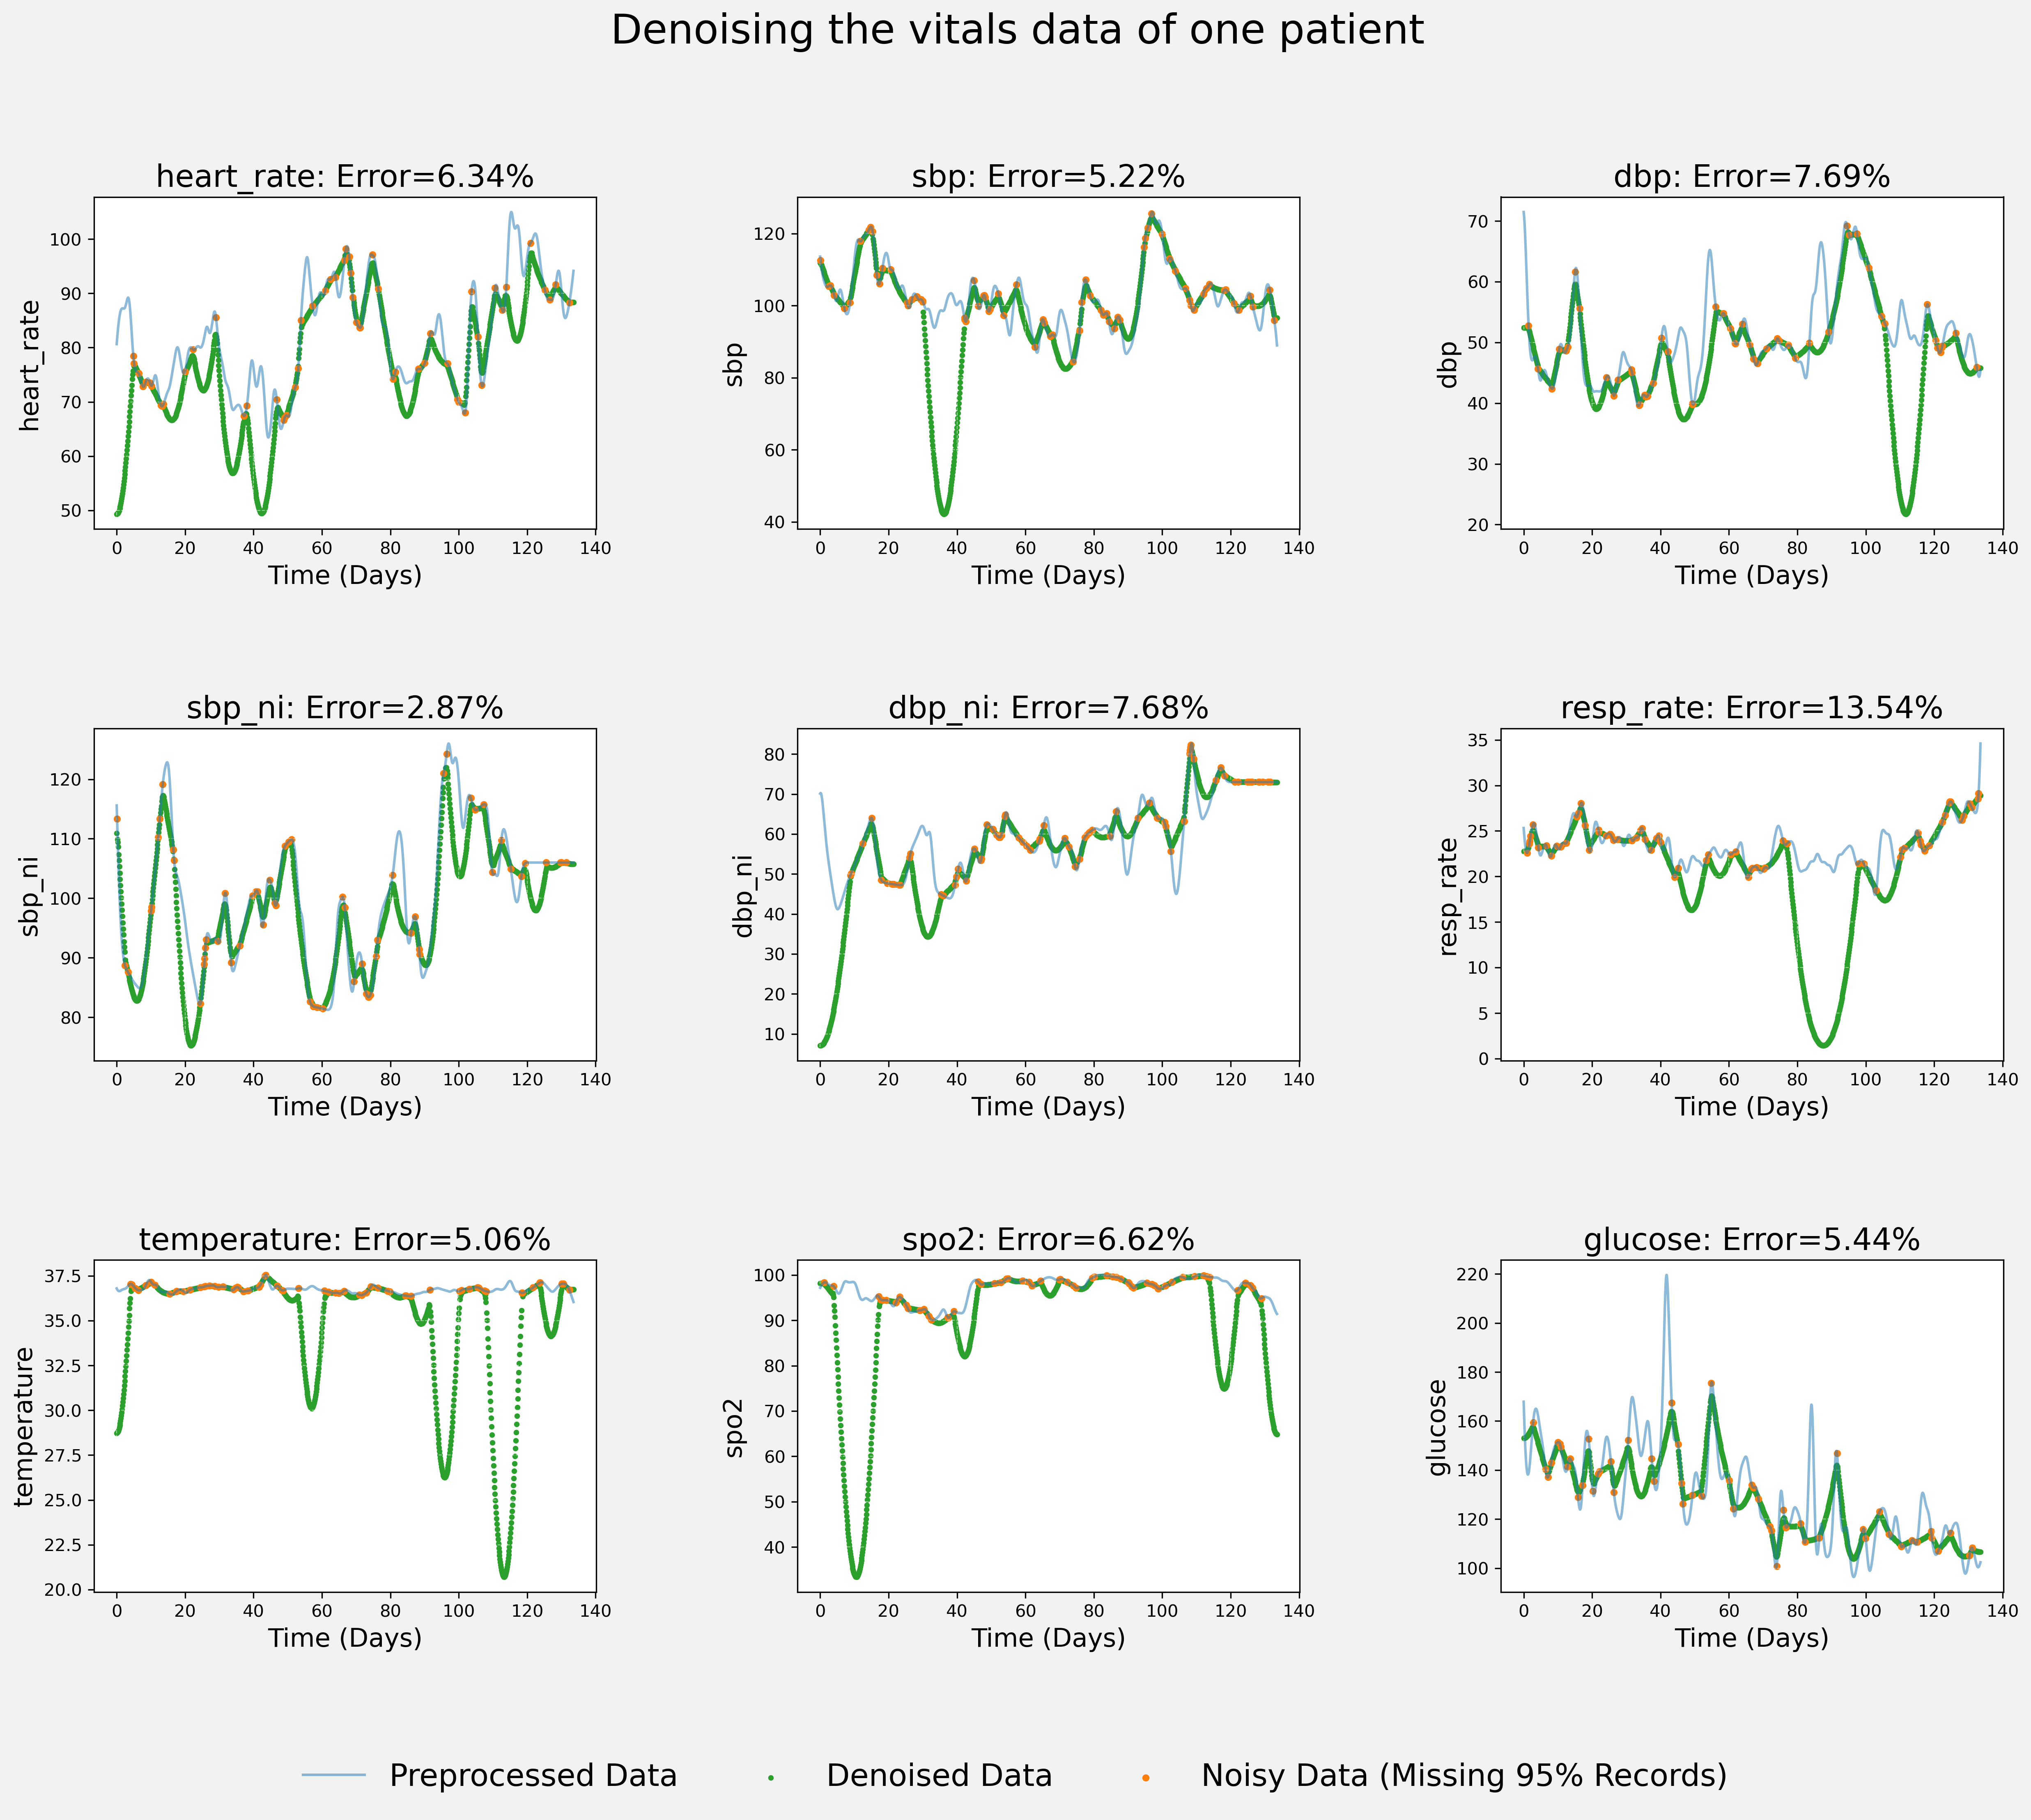

In [65]:
import matplotlib.pyplot as plt

# Set a consistent color scheme
colors = ['#1f77b4', '#aec7e8', '#2ca02c', '#ff7f0e']

# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), dpi=300)
fig.set_facecolor('#f2f2f2')
fig.suptitle('Denoising the vitals data of one patient', fontsize=24, fontname='Arial')
plt.subplots_adjust(hspace=0.6, wspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    # ax.scatter(data_reset_time.offset / 1440, data_reset_time[name], s=.1, c='gray', alpha=.5, label='Original Data')
    ax.plot(data_smo2.offset / 1440, data_smo2[name], alpha=.5, c=colors[0], label='Preprocessed Data')
    ax.scatter(data_denoised.offset / 1440, data_denoised[name], s=5, c=colors[2], label='Denoised Data')
    plot_points = data_noisy[name] != 0
    ax.scatter(data_noisy.offset[plot_points] / 1440, data_noisy[name][plot_points], s=10, c=colors[3], label='Noisy Data (Missing 95% Records)')
    # ax.set_title(f'{name}', fontsize=18, fontname='Arial')
    ax.set_title(f'{name}: Error={mean_absolute_percentage_error(data_smo2[name], data_denoised[name])*100:.2f}%', fontsize=18, fontname='Arial')
    ax.set_xlabel('Time (Days)', fontsize=15, fontname='Arial')
    ax.set_ylabel(name, fontsize=15, fontname='Arial')
    ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

# Create a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=18, frameon=False)

plt.show()


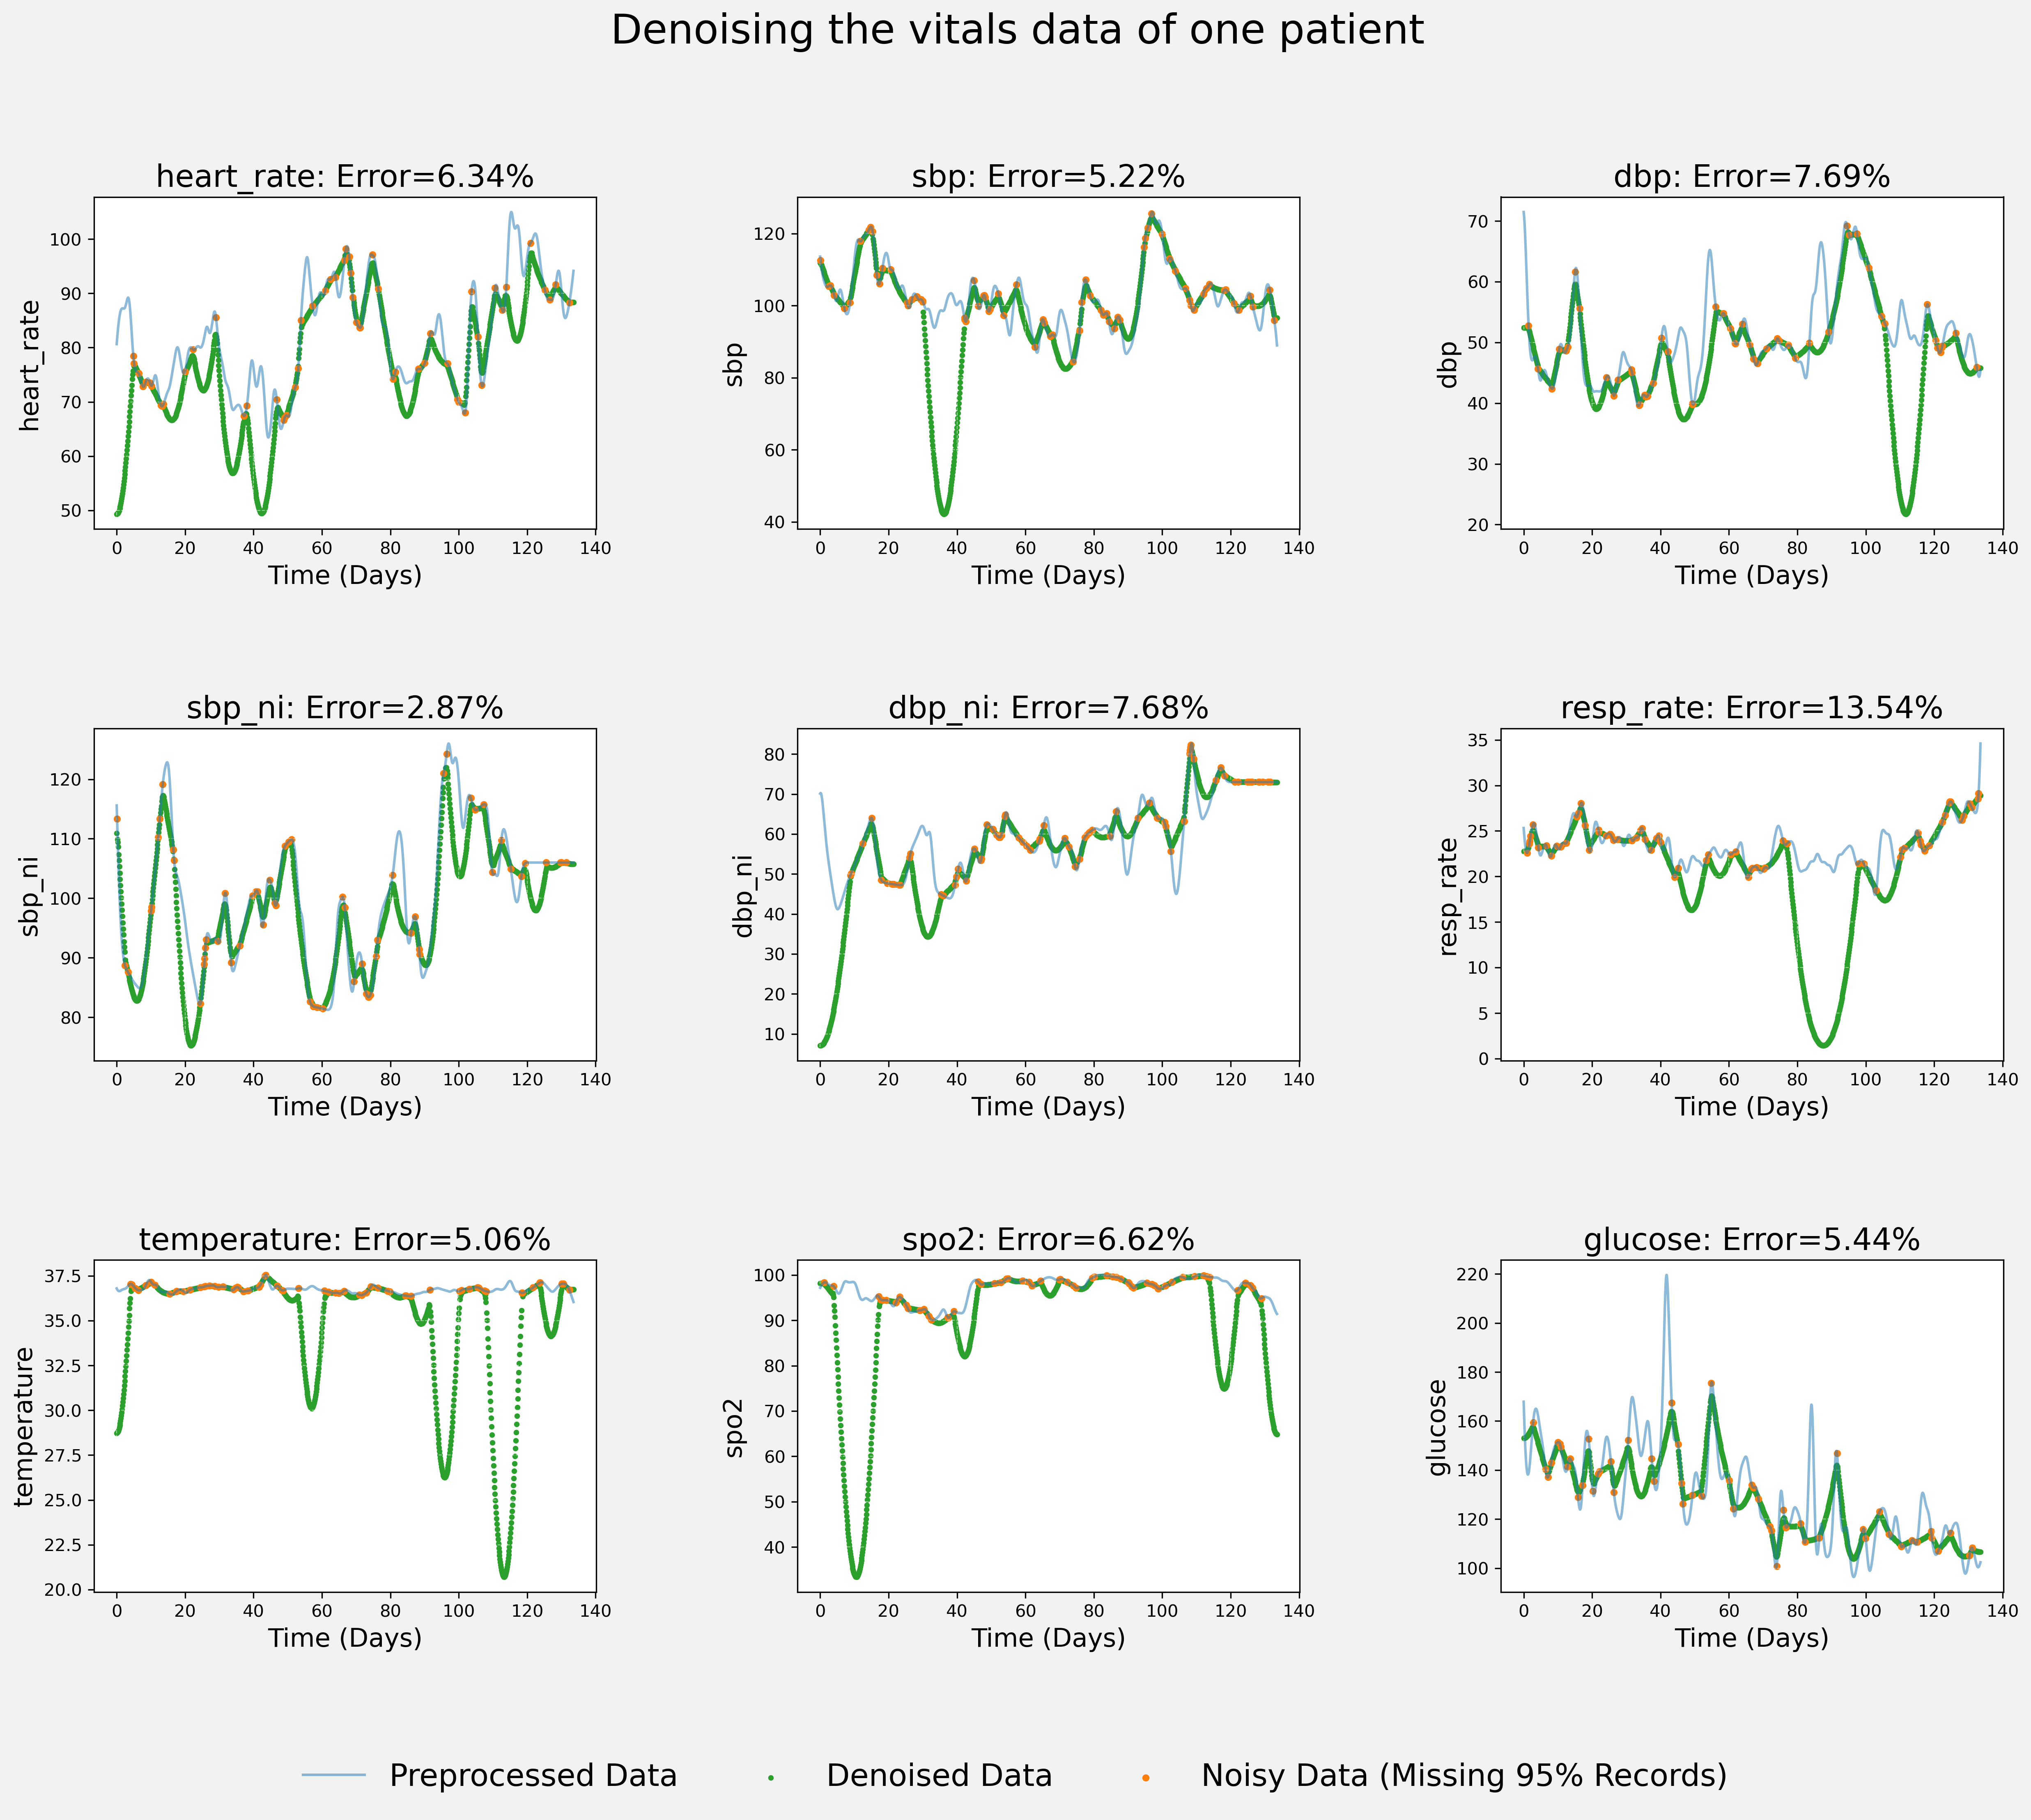

In [66]:
import matplotlib.pyplot as plt

# Set a consistent color scheme
colors = ['#1f77b4', '#aec7e8', '#2ca02c', '#ff7f0e']

# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), dpi=300)
fig.set_facecolor('#f2f2f2')
fig.suptitle('Denoising the vitals data of one patient', fontsize=24, fontname='Arial')
plt.subplots_adjust(hspace=0.6, wspace=0.4)

# Loop through the columns and plot each one
for i, name in enumerate(cols_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    # ax.scatter(data_reset_time.offset / 1440, data_reset_time[name], s=.1, c='gray', alpha=.5, label='Original Data')
    ax.plot(data_smo2.offset / 1440, data_smo2[name], alpha=.5, c=colors[0], label='Preprocessed Data')
    ax.scatter(data_denoised.offset / 1440, data_denoised[name], s=5, c=colors[2], label='Denoised Data')
    plot_points = data_noisy[name] != 0
    ax.scatter(data_noisy.offset[plot_points] / 1440, data_noisy[name][plot_points], s=10, c=colors[3], label='Noisy Data (Missing 95% Records)')
    # ax.set_title(f'{name}', fontsize=18, fontname='Arial')
    ax.set_title(f'{name}: Error={mean_absolute_percentage_error(data_smo2[name], data_denoised[name])*100:.2f}%', fontsize=18, fontname='Arial')
    ax.set_xlabel('Time (Days)', fontsize=15, fontname='Arial')
    ax.set_ylabel(name, fontsize=15, fontname='Arial')
    ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

# Create a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=18, frameon=False)

plt.show()


In [67]:
data_smo2.shape

(1211, 10)